
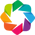

In [1]:
import os
import sys
sys.path.append('/home/user/Desktop/Thesis_Scripts/Modules')

from Tkinter import *
import Tkinter, Tkconstants, tkFileDialog
import Import_module as im
import Filtering_module as fm
import Spiker as sp

import numpy as np 
from h5py import File
import math
import time

import matplotlib
matplotlib.use('TkAgg') #Not case-sensitive
#%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade
import datashader.transfer_functions as tf
hv.extension('bokeh')

### Analyze recordings based on threshold crossings

In [2]:
#Let the user select a dataset and open the h5 file

root = Tk()
root.withdraw()#Remove the root window from the screen without removing it
path = tkFileDialog.askopenfilename(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

/home/user/Desktop/Data/2018-02-05/2011/Trace_20180205_11_50_01.raw.h5


In [3]:
root = Tk()
root.withdraw()
path = tkFileDialog.askdirectory(initialdir = "/home/user/Desktop/Data")
root.destroy()
print path

In [3]:
start = 0
stop = 'end'


begin = time.time()
raw = im.import_rawdata(path,start,stop,modified=False)
end = time.time()
elapsed = end - begin
print 'elapsed time: {0:.1f} seconds'.format(elapsed)

elapsed time: 6.0 seconds


In [4]:
filtdat = fm.Filtering(raw)
filtdat.butter_filter(300,3000)
filtdat.discard_out_of_bounds()
raw=None

Discarded 6.0 traces.
0.0 critical traces.


### Plot the routed electrodes

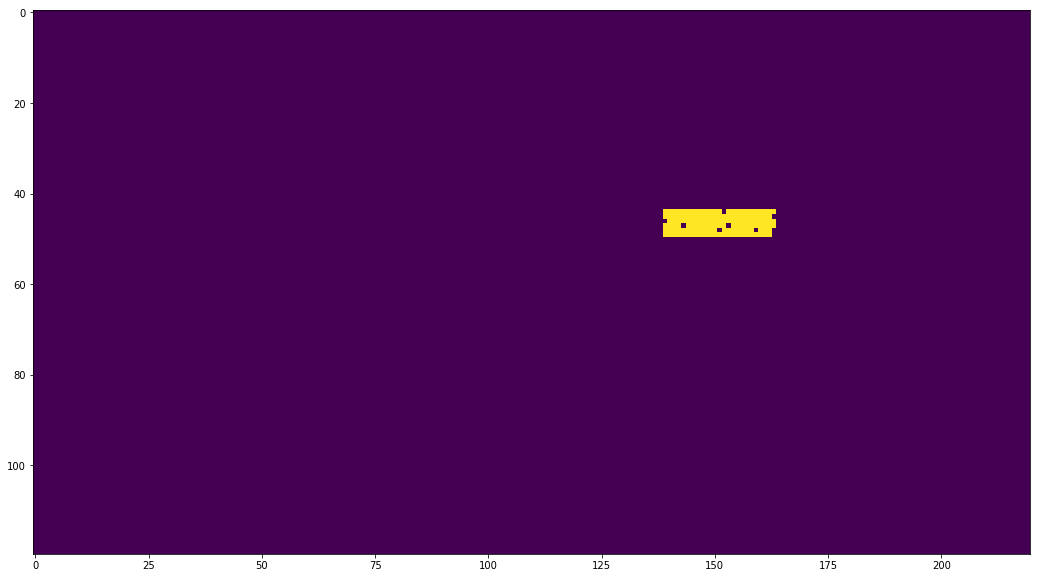

In [11]:
#Single recording
plt.figure(figsize=(25,10))
plt.imshow(filtdat.metadata['electrode_map'])

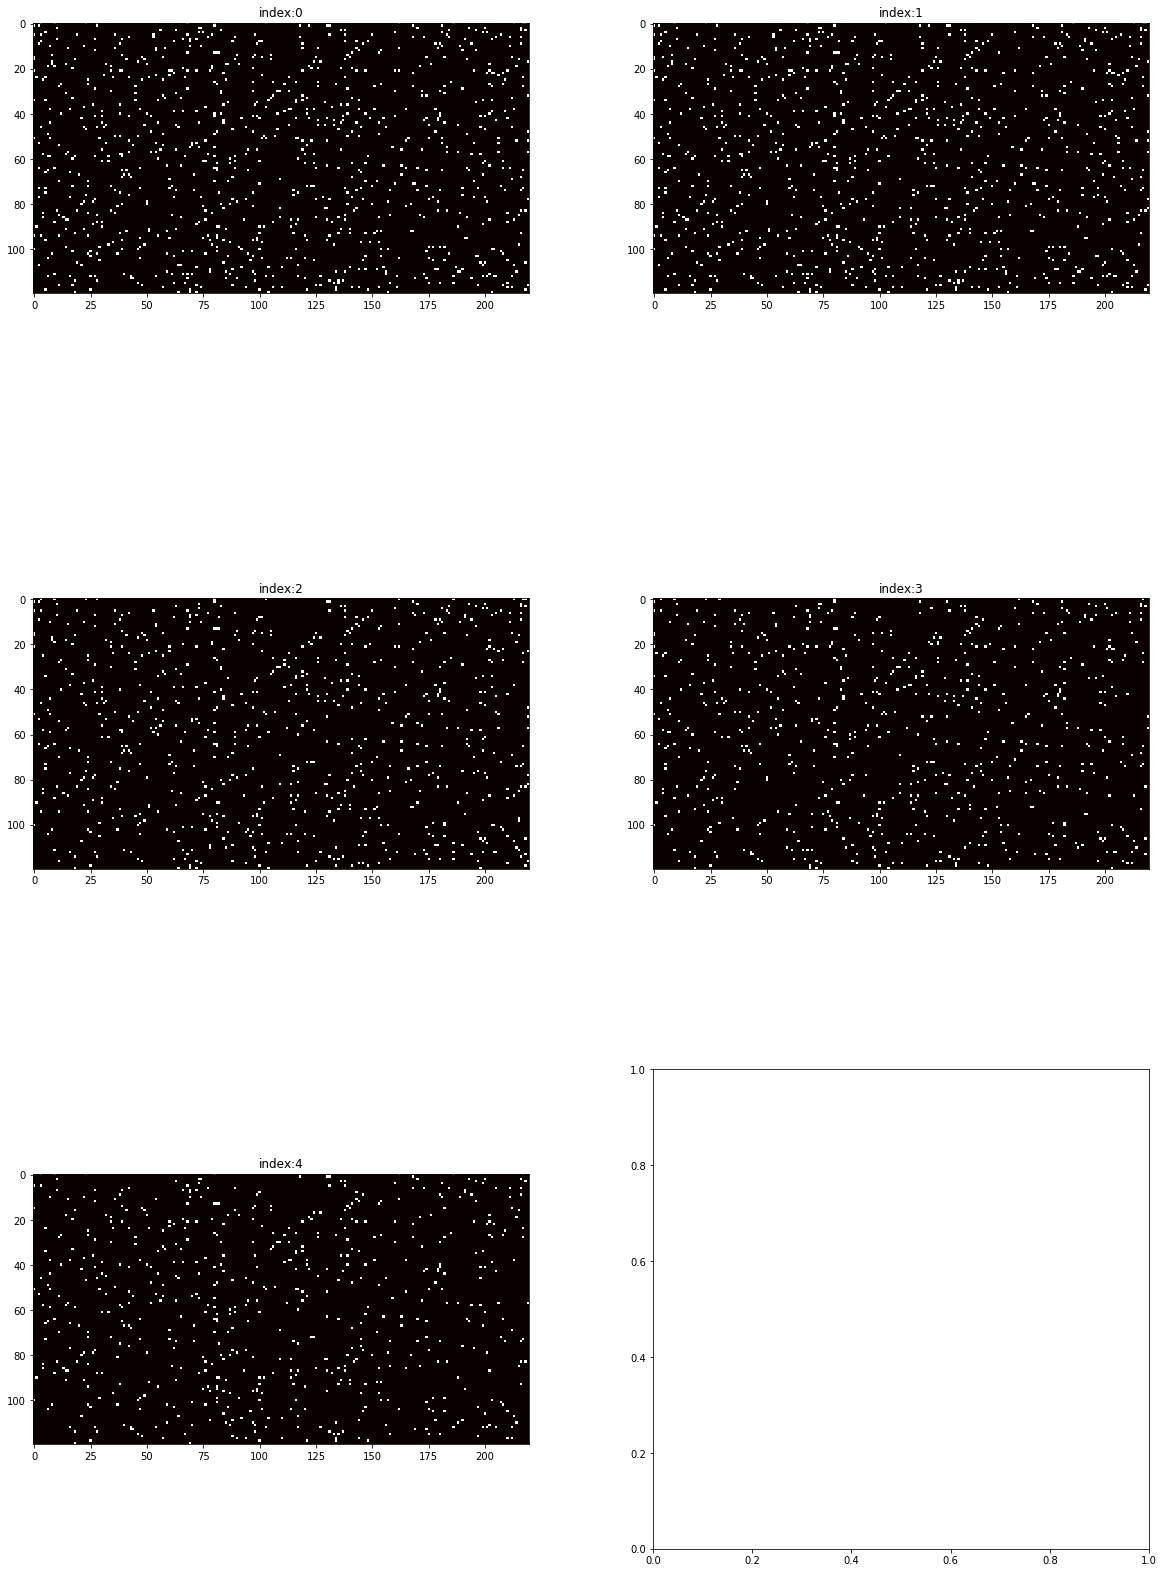

In [419]:
#multiple recordings
num_hor_plot=2
num_ver_plots=3
plot_square_size=10

fig,axarr=plt.subplots(num_ver_plots,num_hor_plot,figsize=(plot_square_size*num_hor_plot,plot_square_size*num_ver_plots))
for ids,s in enumerate(filtdat.metadata):
    ver_idx=ids/num_hor_plot
    hor_idx=ids%num_hor_plot
    axarr[ver_idx,hor_idx].imshow(s['electrode_map'],cmap='hot')
    axarr[ver_idx,hor_idx].set_title('index:'+str(ids))
    
plt.subplots_adjust(wspace=.25)

### Plot all traces

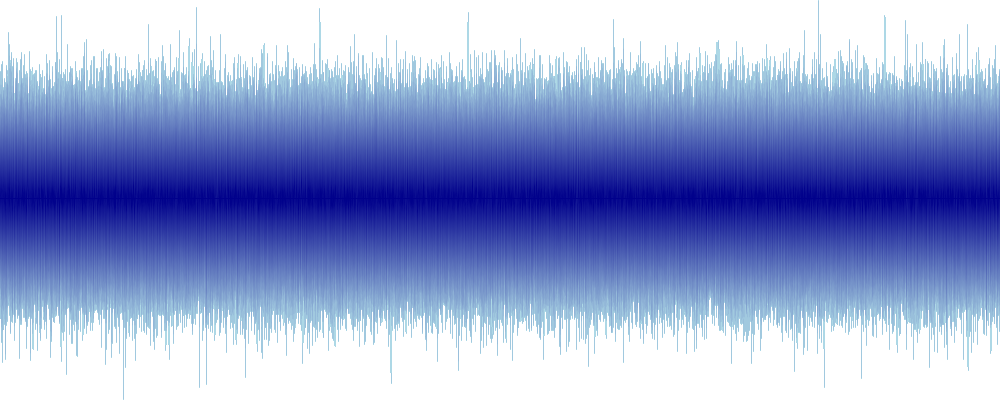

In [9]:
begin =10000
end=30000
d0 = ds.utils.dataframe_from_multiple_sequences(filtdat.metadata['time'][begin:end],filtdat.butter_data[:,begin:end])
cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(d0, 'x', 'y', ds.count())   
img0 = tf.shade(agg, how='eq_hist')
img0

### Plot automatic spike detection

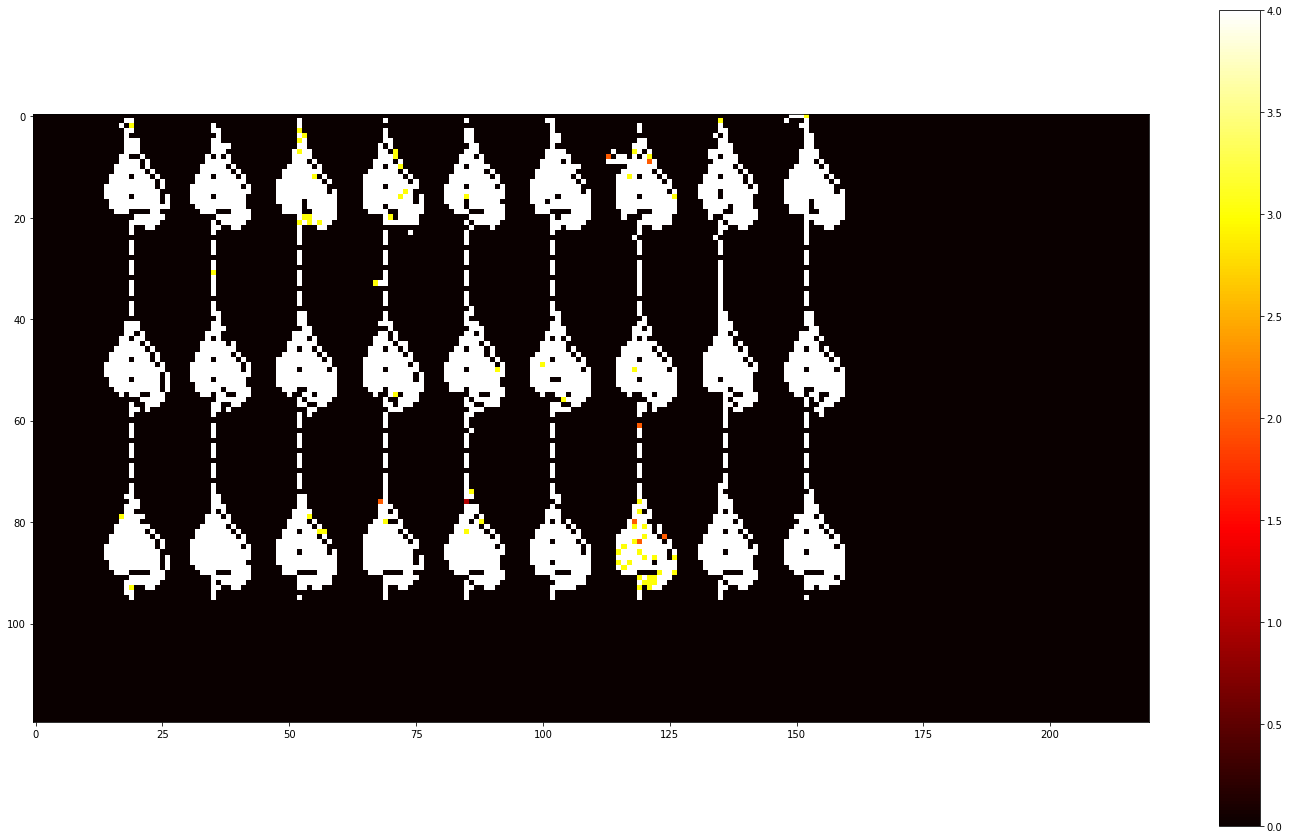

In [138]:
#Plot automatic spike detection

Activity_map = np.zeros((120,220))
x_pos=[]
y_pos=[]
electrodes = []

for i in range(27):

    mask = (filtdat.metadata[i]['SpikeTimes']['framenumber'] >= min(filtdat.metadata[0]['SpikeTimes']['framenumber'])+4000)
    #&(filtdat.metadata[i]['SpikeTimes']['framenumber'] <= max(filtdat.metadata[0]['SpikeTimes']['framenumber'])-1000)
    clean_electrodes = filtdat.metadata[i]['SpikeTimes']['electrode_ind'][mask]
    frames = np.asarray(filtdat.metadata[i]['SpikeTimes']['framenumber'][mask])
    frames -= min(filtdat.metadata[0]['SpikeTimes']['framenumber'])
    unique_electrodes = np.unique(clean_electrodes)
    electrodes.append(zip(clean_electrodes,frames))
    spike_count,bins=np.histogram(clean_electrodes,np.hstack((0,unique_electrodes)))
    y=unique_electrodes/220
    x=unique_electrodes%220
    Activity_map[y,x]+=spike_count
    
fig=plt.figure(figsize=(25,15))
plt.imshow(Activity_map,cmap='hot',vmin=0,vmax=np.max(spike_count)/3,interpolation='nearest')
plt.colorbar()

In [10]:
Activity_map = np.zeros((120,220))
stop = -1
mask = (filtdat.metadata['SpikeTimes']['framenumber'] >= min(filtdat.metadata['SpikeTimes']['framenumber'])+start)&(filtdat.metadata['SpikeTimes']['framenumber'] <= min(filtdat.metadata['SpikeTimes']['framenumber'])+stop)
clean_electrodes = filtdat.metadata['SpikeTimes']['electrode_ind'][mask]
frames = np.asarray(filtdat.metadata['SpikeTimes']['framenumber'][mask])
frames -= min(frames)
unique_electrodes = np.unique(clean_electrodes)
spike_count,bins=np.histogram(clean_electrodes,np.hstack((0,unique_electrodes)))
y=unique_electrodes/220
x=unique_electrodes%220
Activity_map[y,x]+=spike_count

fig=plt.figure(figsize=(25,15))
plt.imshow(Activity_map,cmap='hot',interpolation='nearest')
plt.colorbar()

ValueError: min() arg is an empty sequence

### Spike detection

In [12]:
#Spike detection: Single recording
pos_ind = sp.spiker(5,0.01,filtdat.butter_data,filtdat.metadata['time'],50,-50)
neg_ind = sp.spiker(5,0.01,-1*filtdat.butter_data,filtdat.metadata['time'],50-50)

pos_spikes = [i for i in enumerate(pos_ind) if i[1]]
neg_spikes = [i for i in enumerate(neg_ind ) if i[1]]
print '{0:d} electrodes have positive spikes, {1:d} electrodes have negative spikes'.format(len(pos_spikes),len(neg_spikes))
print 'negative spikes'
print 'rel_ind.\tabs.ind.\ttimings'
for j,i in enumerate(neg_spikes):
    print j,'\t\t',i[0],'\t\t',i[1]
    
print 'positive spikes'
print 'rel_ind.\tabs.ind.\ttimings'
for j,i in enumerate(pos_spikes):
    print j,'\t\t',i[0],'\t\t',i[1]

141 electrodes have positive spikes, 141 electrodes have negative spikes
negative spikes
rel_ind.	abs.ind.	timings
0 		1 		[887, 4915, 5623, 5958, 6109, 6530, 6585, 6763, 7062, 7336, 7648, 7851, 11476, 12719, 14102, 14590, 14986, 15263, 17431, 18065, 20482, 25845, 32696, 36977, 40745, 46777, 47056, 51505, 56811, 57063, 68826, 71949, 76469, 80154, 84005, 85889, 92976, 94910, 96875, 100395, 100674, 105397, 107049, 112622, 115527, 126134, 131481, 133498, 140936, 146325, 151387, 158489, 159401, 160818, 163718, 166309, 174754, 179513, 182397, 188557, 192852, 194734, 199740, 205999, 208663, 211491, 213033, 216862, 231492, 235050, 246208, 253920, 257979, 258258, 258715, 259015, 265931, 268205, 273657, 274085, 277177, 278801, 288141, 292040, 295267, 295778, 295922, 296045, 296315, 296546, 296875, 296896, 297078, 297627, 297988, 300945, 301749, 302200, 303292, 303493, 304313, 305134, 305360, 305909, 310194, 310566, 314746, 318839, 323816, 329118, 329338, 333337]
1 		3 		[890, 1334, 4918, 5710, 

In [421]:
#Spike Detection: Multiple recordings: Note that filtdat.butter_data is a list.
pos_ind = [sp.spiker(5,0.01,j,filtdat.metadata[i]['time'],4000,-50) for i,j in enumerate(filtdat.butter_data)]
neg_ind = [sp.spiker(5,0.01,-1*j,filtdat.metadata[i]['time'],4000,-50) for i,j in enumerate(filtdat.butter_data)]

pos_spikes = [[i for i in enumerate(j) if i[1]] for j in pos_ind]
neg_spikes = [[i for i in enumerate(j) if i[1]] for j in neg_ind]
print 'Rec. \t+spike \t-spike'
for i in range(len(pos_ind)):
    print i, '\t',len(pos_spikes[i]), '\t', len(neg_spikes[i])

Rec. 	+spike 	-spike
0 	191 	341
1 	140 	319
2 	213 	317
3 	219 	345
4 	202 	307


### show loci of detected spikes

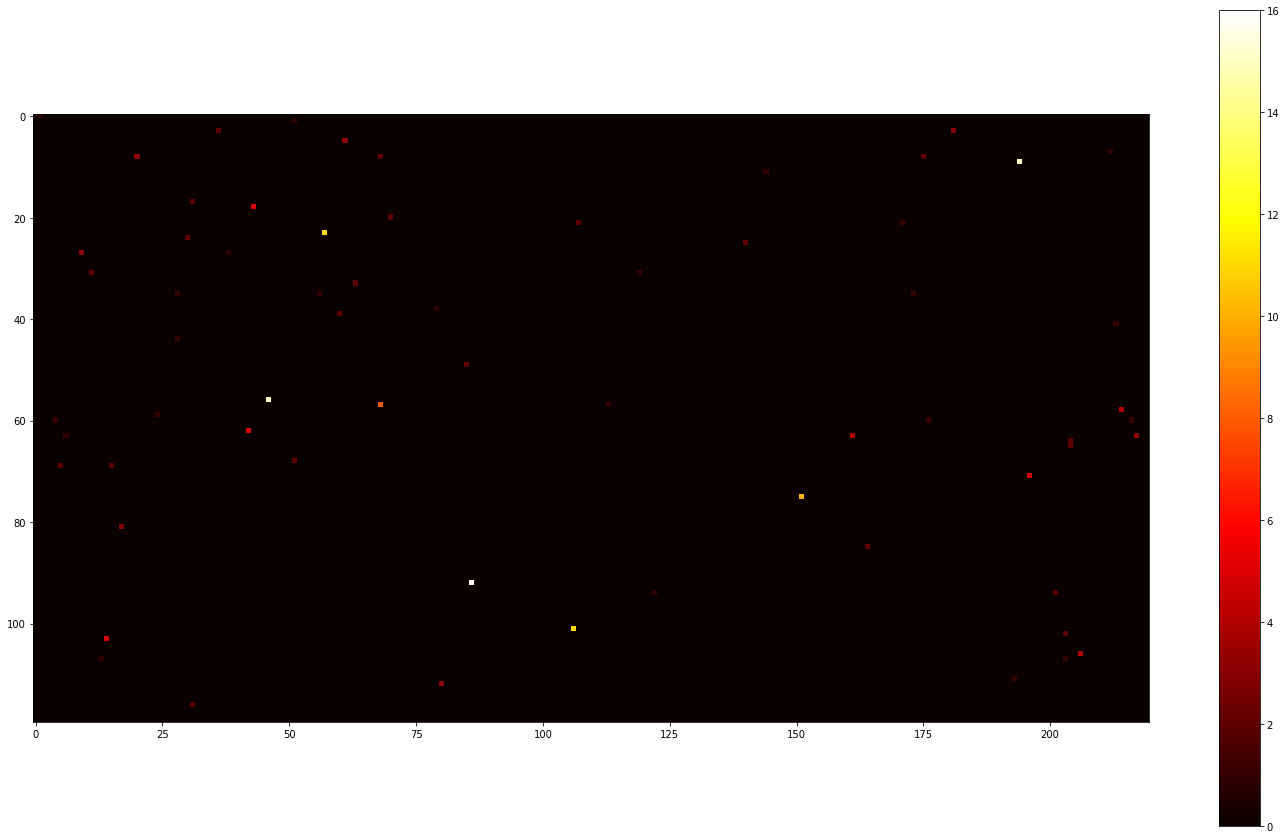

In [12]:
Activity_map = np.zeros((120,220))

counts = np.asarray([len(i[1]) for i in pos_spikes])
inds = np.asarray([filtdat.metadata['clean_abs_inds'][i[0]] for i in pos_spikes])
y=inds/220
x=inds%220
Activity_map[y,x]=counts

fig=plt.figure(figsize=(25,15))
plt.imshow(Activity_map,cmap='hot',interpolation='nearest')
plt.colorbar()

### Compare custom to automatic spike detection

In [66]:
# Print the electrodes with highest spike rate in the automatic spike detection

import collections
counter = collections.Counter(sorted(clean_electrodes))
print counter.most_common(3)

[(8400, 4), (12842, 3), (12862, 3)]


In [86]:
# Get the corresponding frames
frames_o_i = frames[np.where(clean_electrodes == 12862)[0]]

In [85]:
#And the relative index
rel_ind = np.where(filtdat.metadata['clean_abs_inds']==12862)[0]
print rel_ind[0]

395


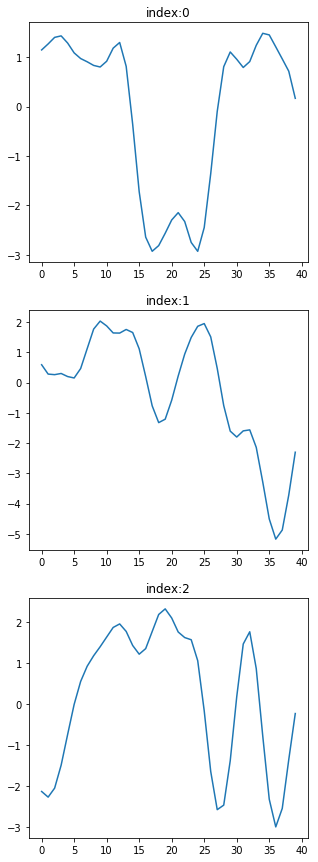

In [87]:
# Plot the spikes
num_ver_plots=len(frames_o_i)
plot_square_size=5

fig,axarr=plt.subplots(num_ver_plots,1,figsize=(plot_square_size*1,plot_square_size*num_ver_plots))
for ids,s in enumerate(frames_o_i):
    axarr[ids].plot(filtdat.butter_data[rel_ind[0],s-20:s+20])
    axarr[ids].set_title('index:'+str(ids))
    
plt.subplots_adjust(wspace=.25)

### -> Automatic Spike detection doesnt make sense

### Plot detected spikes on corresponding traces for a single recording

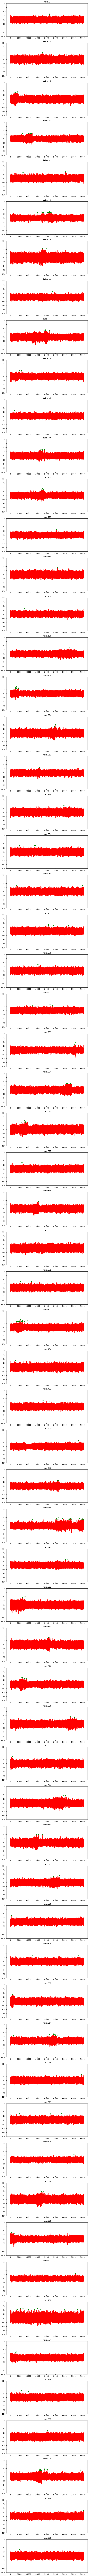

In [13]:
num_plots = len(pos_spikes)
plot_square_size=5

fig,axarr=plt.subplots(num_plots,1,figsize=(10,plot_square_size*num_plots))
for ids,s in enumerate(pos_spikes):
    axarr[ids].plot(filtdat.butter_data[s[0],:],color='r')
    axarr[ids].plot(s[1],filtdat.butter_data[s[0],s[1]],'o',color='g')
    axarr[ids].set_title('index:'+str(s[0]))
    axarr[ids].set_ylim((-10,10))
    
plt.subplots_adjust(wspace=.25)

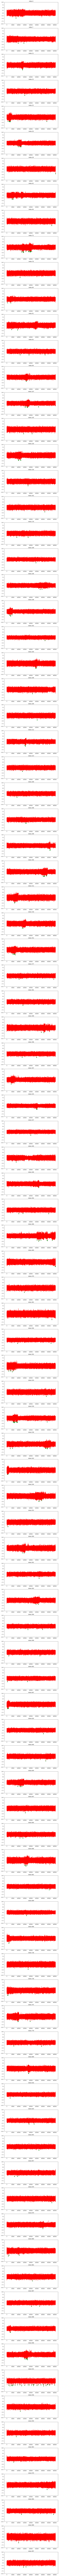

In [14]:
num_plots = len(neg_spikes)
plot_square_size=5

fig,axarr=plt.subplots(num_plots,1,figsize=(10,plot_square_size*num_plots))
for ids,s in enumerate(neg_spikes):
    axarr[ids].plot(filtdat.butter_data[s[0],:],color='r')
    axarr[ids].plot(s[1],filtdat.butter_data[s[0],s[1]],'o',color='g')
    axarr[ids].set_title('index:'+str(s[0]))
    axarr[ids].set_ylim((-10,10))
    
plt.subplots_adjust(wspace=.25)

### Find the most spiking electrodes on multiple recordings

In [13]:
spiking_no = []
spiking_el = []
spiking_times = []
for i in neg_spikes:
    spiking_no.append(len(i[1]))
    spiking_el.append(i[0])
    spiking_times.append(i[1])

zipped_vals = zip(spiking_el,spiking_times,spiking_no)
sorted_spikes = sorted(zipped_vals,key = lambda t: t[2],reverse=True)

print 'El.Ind. \tspike_count'
for i in sorted_spikes:
    print i[0], '\t\t',i[2]

El.Ind. 	spike_count
141 		287
27 		286
8 		280
85 		243
18 		229
28 		203
129 		163
42 		156
134 		149
6 		145
139 		145
22 		144
90 		144
15 		143
26 		143
36 		142
7 		137
51 		136
63 		129
100 		129
17 		128
61 		127
34 		126
73 		125
65 		124
50 		122
3 		121
114 		121
135 		120
78 		119
25 		118
55 		118
143 		118
12 		116
44 		114
54 		113
1 		112
31 		112
40 		112
35 		111
43 		111
89 		111
106 		111
110 		111
121 		111
117 		109
101 		108
45 		107
48 		106
127 		106
21 		105
107 		105
58 		104
92 		104
108 		104
80 		103
70 		102
75 		102
145 		102
32 		101
96 		101
38 		100
77 		99
83 		99
95 		99
59 		98
66 		98
56 		97
74 		97
103 		97
67 		96
104 		96
112 		96
128 		96
137 		96
16 		93
82 		93
138 		93
132 		92
88 		90
102 		89
84 		86
98 		86
105 		86
126 		85
140 		85
69 		84
57 		82
4 		81
24 		79
9 		77
118 		77
109 		76
113 		74
13 		72
11 		71
146 		69
33 		67
5 		66
94 		66
62 		65
47 		62
76 		59
14 		57
122 		57
20 		55
23 		55
124 		55
79 		54
99 		54
41 		52
81 

### Overlay and plot the spikes

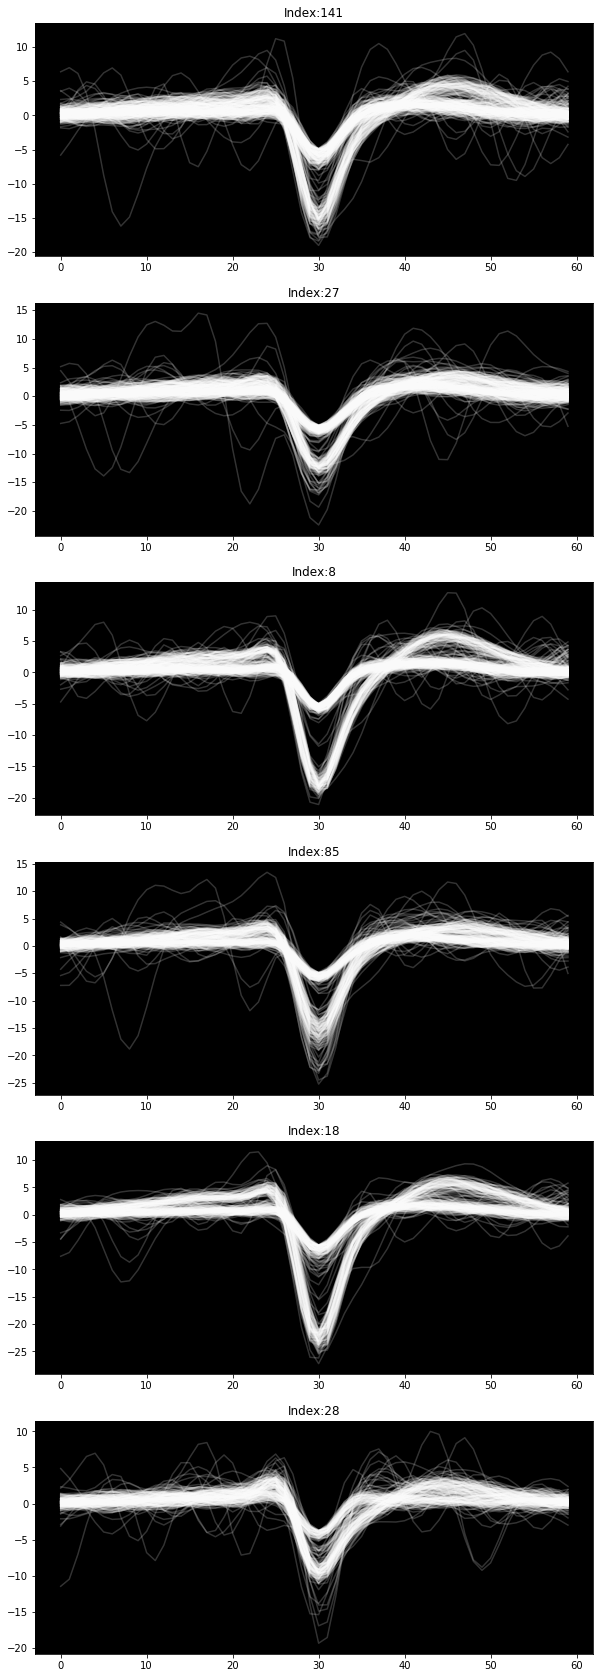

In [14]:
no_plots = 6
plot_square_size=5

fig,axarr=plt.subplots(no_plots,1,figsize=(10,plot_square_size*no_plots))

for i,j in enumerate(sorted_spikes):
    if i == no_plots:
        break
    for k in j[1]: #iterate over all timings
        axarr[i].plot(filtdat.butter_data[j[0],k-30:k+30],alpha=0.2,color='w')
    axarr[i].set_title('Index:'+str(j[0]))
    axarr[i].set_facecolor('k')
#fig.savefig(path+'/overlay_pos_spikes_el_ind_154.png',bbox_inches='tight',pad_inches=0)

### Find the most spiking electrodes on multiple recordings

In [422]:
spiking_electrodes = []
for i in neg_spikes:
    for j in i:
        spiking_electrodes.append(j[0])
print spiking_electrodes

[1, 3, 4, 5, 7, 12, 14, 16, 17, 21, 23, 26, 29, 32, 33, 41, 43, 44, 47, 54, 61, 63, 70, 75, 76, 77, 80, 84, 85, 86, 87, 88, 89, 91, 100, 105, 106, 109, 115, 118, 122, 125, 126, 131, 134, 144, 146, 154, 156, 162, 164, 166, 174, 175, 177, 179, 185, 189, 194, 195, 196, 198, 199, 202, 207, 209, 212, 213, 217, 218, 219, 229, 231, 232, 233, 237, 241, 248, 250, 255, 266, 270, 271, 277, 279, 282, 283, 287, 290, 294, 297, 305, 306, 310, 312, 316, 321, 328, 332, 335, 336, 338, 345, 348, 349, 354, 371, 374, 380, 381, 388, 392, 393, 394, 401, 407, 412, 415, 417, 418, 420, 423, 425, 427, 428, 436, 440, 441, 445, 448, 450, 455, 462, 471, 474, 478, 482, 483, 485, 493, 494, 499, 502, 505, 509, 511, 514, 516, 523, 525, 532, 535, 539, 544, 548, 551, 557, 561, 564, 571, 574, 577, 582, 583, 585, 586, 589, 592, 593, 596, 599, 603, 609, 612, 613, 616, 621, 622, 626, 627, 631, 632, 634, 635, 638, 641, 642, 646, 649, 652, 658, 666, 669, 670, 671, 674, 675, 683, 686, 687, 688, 689, 698, 702, 703, 706, 707, 708

In [424]:
import collections
counter = collections.Counter(sorted(spiking_electrodes))
print counter.most_common(10)

[(4, 5), (5, 5), (12, 5), (14, 5), (17, 5), (21, 5), (26, 5), (33, 5), (75, 5), (80, 5)]


### Extract the spike timings of a specific electrode

In [425]:
el_index = 4
spiking_times = [[] for _ in range(5)]
for p,i in enumerate(pos_spikes):
    for j in i:
        if j[0]==el_index:
            spiking_times[p]=j[1]
            
print spiking_times

[[4559, 9595, 12252, 13931, 16623, 33966, 36079, 40002, 50648], [39804, 49333, 53260], [5521, 13985, 15859, 17352, 24285, 31655, 32790, 38977, 46036, 55336, 57833, 65641], [10214, 10723, 11594, 12643, 16618, 17027, 19116, 23499, 26695, 30987, 36860, 38490, 39364, 40883, 41736, 42862, 47242, 48563, 51605, 53463, 56388, 65298], [5204, 6536, 7743, 10821, 12729, 14676, 16796, 18252, 19920, 21145, 21379, 24052, 26644, 29642, 30463, 31306, 31950, 33243, 34148, 34606, 35017, 35751, 37591, 40340, 42374, 45571, 46318, 48984, 50661, 60126, 65017]]


### Extract the traces of a specific electrode

In [427]:
el_index = 4

traces_oi=np.zeros((5,60000))
for i,j in enumerate(filtdat.butter_data):
    traces_oi[i,:]=j[el_index,:60000]

### Overlay al spikes on one electrode over all recordings

/home/user/anaconda2/envs/ds/lib/python2.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


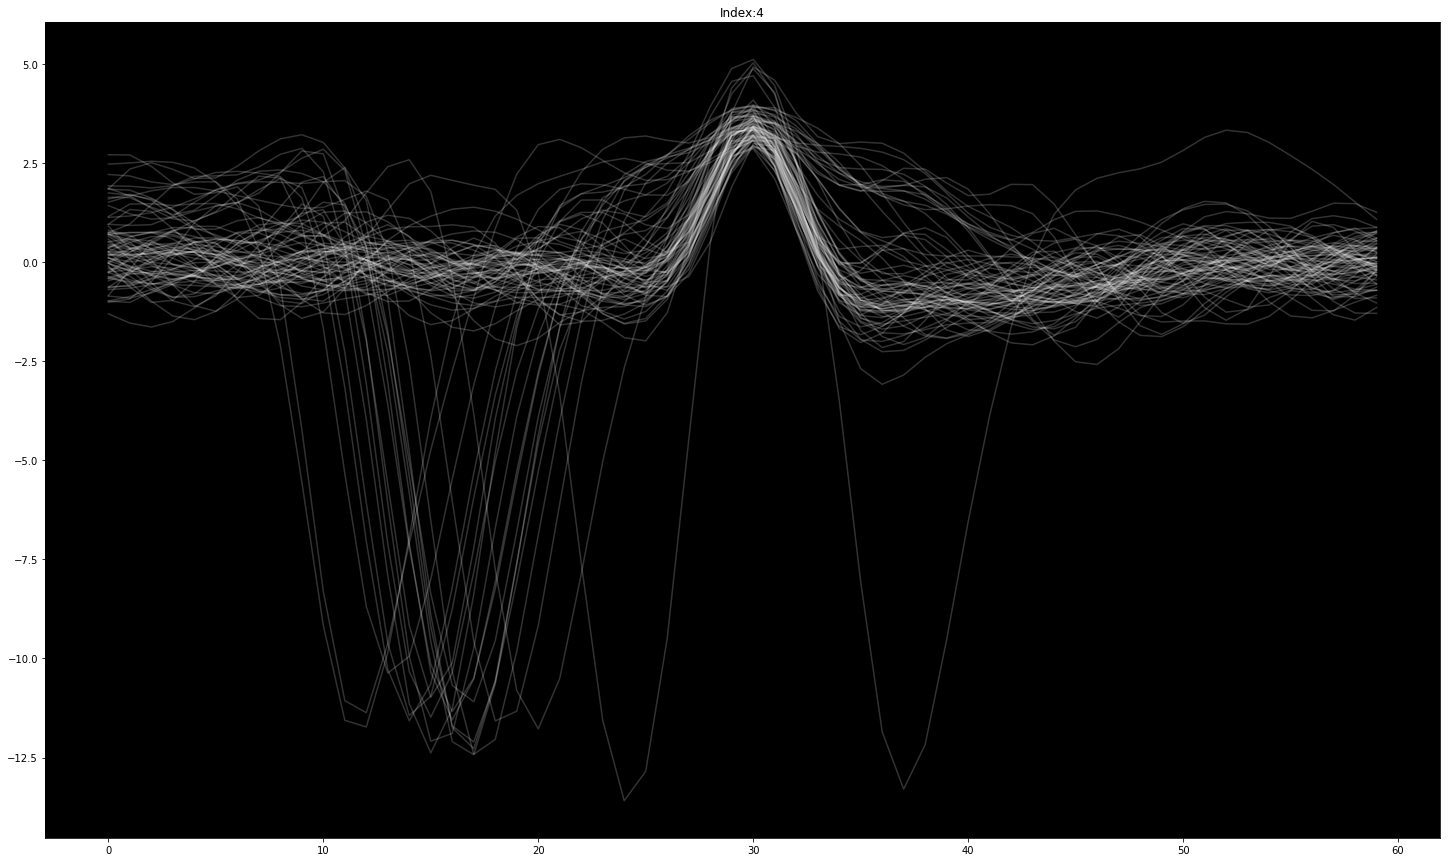

In [428]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
for i,times in enumerate(spiking_times):
    if times:
        for k in times:
            ax.plot(traces_oi[i,k-30:k+30],alpha=0.2,color='w')
ax.set_title('Index:'+str(el_index))
ax.set_axis_bgcolor('k')
fig.savefig(path+'/overlay_pos_spikes_el_ind_154.png',bbox_inches='tight',pad_inches=0)